In [2]:
# To support both python 2 and python 3# To su 
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
### Import MNIST data set for classifcation excercises

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
# analyse data set
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

Saving figure some_digit_plot


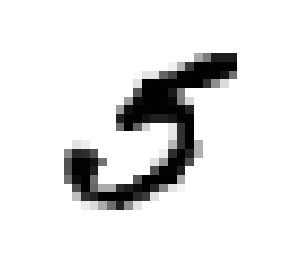

In [5]:
# draw a random entry 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

In [6]:
# check label
y[36000]

5.0

In [7]:
# creat train and test data set
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

#shuffle data set to improve cross-validation results (current set is sortet by digit)
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [8]:
#train binary classificator for classifying 5 against none 5, set "5" to be true vs. everything else to false
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
y_train_5

array([False, False, False, ..., False, False, False], dtype=bool)

In [10]:
### fitting a stochastic gradient classifier (SGD)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=10, tol=None, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=10, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [11]:
#result shows true for predicting a 5, which is correct
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [12]:
### checking quality measures for trained model

#implement cross validation without using cross_val_score for more control

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42) #creating 3 folds with fixed random state

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9486
0.9654
0.957


In [13]:
#doing the same cross validation using cross_val_score

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9486,  0.9654,  0.957 ])

In [14]:
### create a dumb classifier, to set current results into perspective

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.909  ,  0.90715,  0.9128 ])

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

### create a confusion matrix to visualize and calculate precision & recall

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

#result shows [true negatives, false positives], [false negatives, true positives]

array([[53606,   973],
       [ 1607,  3814]])

In [16]:
#calculate precision and recall

from sklearn.metrics import precision_score, recall_score

print("Precision Score: ", np.round(precision_score(y_train_5, y_train_pred),decimals=3))
print("Recall Score: ", np.round(recall_score(y_train_5, y_train_pred), decimals=3))

Precision Score:  0.797
Recall Score:  0.704


In [17]:
# combine precision and recall in one metric = F1Score

from sklearn.metrics import f1_score

print("F1 Score: ", np.round(f1_score(y_train_5, y_train_pred), decimals=3))

F1 Score:  0.747


In [18]:
### relationship between recall and precision

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 1206.46829305])

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Saving figure precision_recall_curve


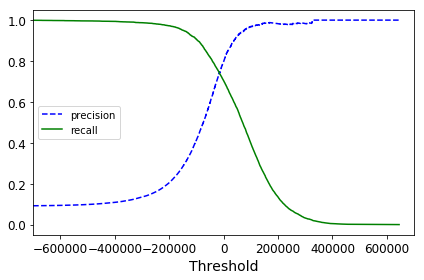

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.xlim([-700000,700000])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
save_fig("precision_recall_curve")
plt.show()


Saving figure roc_curve


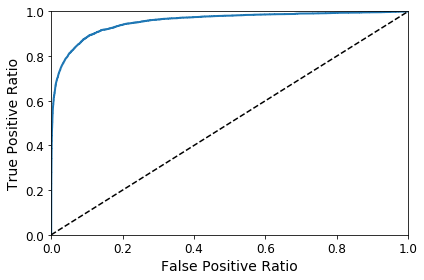

In [21]:
### Plot ROC Curve (Receiver Operating Characteristic)

from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    
plot_roc_curve(fpr, tpr)
save_fig("roc_curve")
plt.show()

In [22]:
# calculate ROC AUC (Area ander the Curve) = Quality Measure for classifier
# perfect clasifier AUC = 100%, random classifier, AUC = 50%

from sklearn.metrics import roc_auc_score
print("ROC AUC Score: ", np.round(roc_auc_score(y_train_5, y_scores), decimals=3)*100, "%")

ROC AUC Score:  95.5 %


In [23]:
### train random forest classifier and compare AUC with linear classifier
# need to use predict_proba() instead of decision_function()

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

Saving figure ROC-Curve-RandomForest_vs_Linear


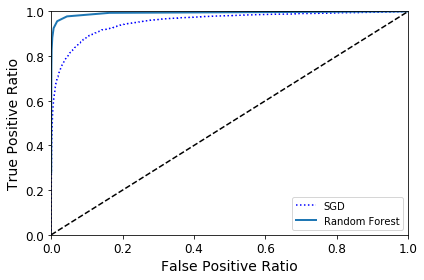

In [24]:
# calculate scores instead of probabilities

y_scores_forest = y_probas_forest[:,1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right")
save_fig("ROC-Curve-RandomForest_vs_Linear")
plt.show()

In [25]:
#calculate ROC AUC for random forest

y_forest_predict = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

print("ROC AUC Score Random Forest: ", np.round((roc_auc_score(y_train_5, y_scores_forest)), decimals=3)*100, "%")
print("Precision Random Forest: ", np.round((precision_score(y_train_5, y_forest_predict)), decimals=3)*100, "%")
print("Recall Score Random Forest: ", np.round((recall_score(y_train_5, y_forest_predict)), decimals=3)*100, "%")

ROC AUC Score Random Forest:  99.3 %
Precision Random Forest:  98.5 %
Recall Score Random Forest:  82.8 %


In [26]:
### train a mutiple categorie classifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [27]:
# analyse decision function to see score per category
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -86880.99526464, -237672.82817877, -166400.74040071,
        -131594.15873554, -191845.64360797,    1206.46829305,
        -330563.87557331, -241281.56362563, -308221.30939119,
        -314369.41736179]])

In [28]:
# check idx of highest value via numpy
np.argmax(some_digit_scores)

5

In [29]:
# select category label for idx
sgd_clf.classes_, sgd_clf.classes_[5]

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]), 5.0)

In [30]:
### train a OneVsOneClassifier (OvO)
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=None, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [31]:
# check number of OvO classifiers
len(ovo_clf.estimators_)

45

In [32]:
### train a random forest multi classifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [33]:
# check probability per category item
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [34]:
# check quality measures of random forest classifier using cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.87312537,  0.84179209,  0.87318098])

In [35]:
# improve classifier via feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91196761,  0.91149557,  0.90843627])

In [36]:
### Error Analyses ###

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) #predict all values
conf_mx = confusion_matrix(y_train, y_train_pred) #compare predicted values vs. labels using confusion matrix
conf_mx

array([[5730,    2,   23,    8,   11,   43,   51,    8,   43,    4],
       [   1, 6472,   46,   25,    6,   45,    5,   12,  119,   11],
       [  47,   35, 5351,  101,   85,   24,   89,   53,  160,   13],
       [  47,   39,  136, 5359,    1,  223,   34,   54,  142,   96],
       [  14,   27,   40,   11, 5356,    8,   54,   33,   94,  205],
       [  65,   40,   36,  186,   68, 4610,  102,   32,  195,   87],
       [  30,   24,   45,    2,   45,   98, 5614,    5,   54,    1],
       [  25,   17,   74,   29,   54,   13,    6, 5798,   19,  230],
       [  45,  139,   68,  154,   10,  150,   57,   25, 5080,  123],
       [  39,   32,   30,   86,  167,   34,    2,  203,   88, 5268]])

Saving figure Confusion Matrix


/Users/bernd/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


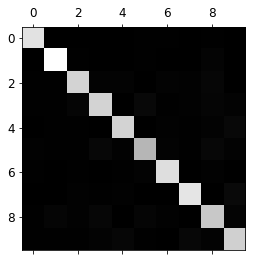

In [37]:
plt.matshow(conf_mx, cmap=plt.cm.gray) # plot confusion matrix using matplotlib
save_fig("Confusion Matrix")
plt.show()

Saving figure Normalized Confusion Matrix


/Users/bernd/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


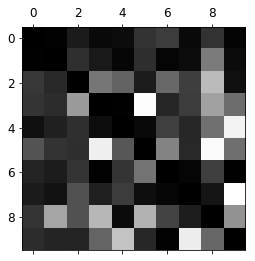

In [38]:
rows_sums = conf_mx.sum(axis=1, keepdims=True) # calculate relative errors
norm_conf_mx = conf_mx / rows_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray) # plot confusion matrix using matplotlib
save_fig("Normalized Confusion Matrix")
plt.show()

In [39]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

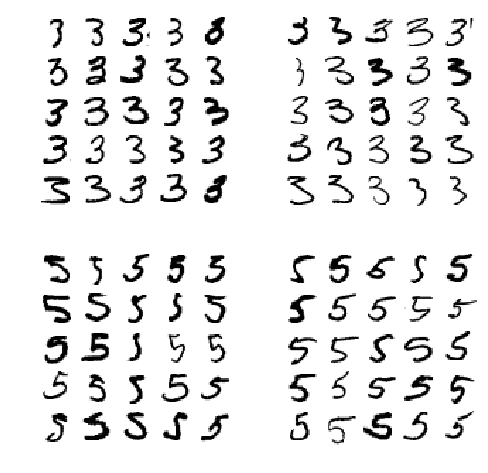

In [40]:
X_aa = X_train[(y_train == 3) & (y_train_pred == 3)] # correct
X_ab = X_train[(y_train == 3) & (y_train_pred == 5)] # incorrect
X_ba = X_train[(y_train == 5) & (y_train_pred == 3)] # incorrect
X_bb = X_train[(y_train == 5) & (y_train_pred == 5)] # correct

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

In [ ]:
#train a classifier with multiple labels
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
#calculate F1 score for every label
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')
# use average='weighted' for unevenly distributed labels

In [ ]:
### classifcation with multiple outputs
noise = rnd.randint(0, 100, len(X_train), 784)
X_train_mod = X_train + noise
noise = rnd.randint(0, 100, len(X_test), 784)
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mode[some_digit]])
plot_digit(clean_digit)